In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import avg
from pyspark.sql.functions import expr
from pyspark.sql.functions import count
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

In [2]:
def how_much_data_do_i_have():
    spark = SparkSession.builder.master("local[8]").appName("Restaurant Home Prices").getOrCreate()
    # number of zip codes from zillow
    zillow_df = spark.read.csv('input/zillow/singlefamily_by_zipcode.csv', header=True)
    print("Number of zip codes from zillow: ", zillow_df.count())
    # number of zip codes in clusters
    clusters_df = spark.read.option("multiline",True).json("input/cluster") 
    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    print("Number of zip codes in clusters: ", clusters_df.count())
    # number of clusters
    clusters_df = spark.read.option("multiline",True).json("input/cluster") 
    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.select("cluster_code").distinct()
    print("Number of clusters: ", clusters_df.count() )
    # number of businesses
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    print("Number of businesses: ", restaurants_df.count())

    spark.stop()

how_much_data_do_i_have()

24/05/03 22:07:04 WARN Utils: Your hostname, endeavour resolves to a loopback address: 127.0.1.1; using 192.168.0.122 instead (on interface wlan0)
24/05/03 22:07:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/03 22:07:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of zip codes from yelp:  26239
Number of zip codes in clusters:  3455
Number of clusters:  69


Number of businesses:  17211


+--------------+-------------------+
|rounded_rating|           variance|
+--------------+-------------------+
|           0.0|-18.653689490282698|
|           0.5| 13.983255396697365|
|           1.0|-27.944034294395784|
|           1.5| -6.062397638451541|
|           2.0|-11.875117875896061|
|           2.5| -5.985555910465334|
|           3.0|  5.014365179700877|
|           3.5|  8.369638187906553|
|           4.0| 19.234590018923925|
|           4.5|   18.3447505266776|
|           5.0|  -38.1966657329909|
+--------------+-------------------+



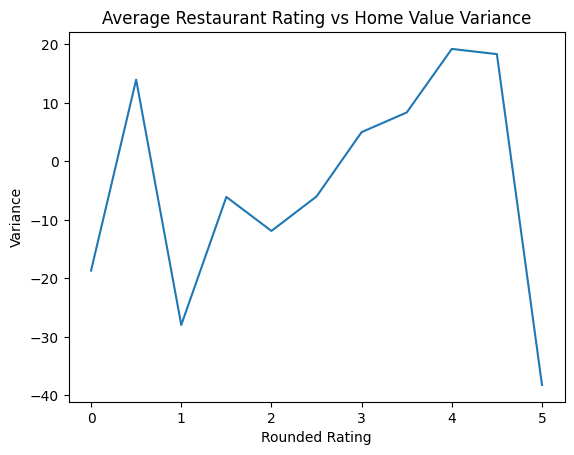

Correlation between rating and home value compared to cluster average: 0.12616208056387787


In [3]:
def average_restaurant_rating_vs_home_value():
    spark = SparkSession.builder.master("local[8]").appName("Restaurant Home Prices").getOrCreate()

    clusters_df = spark.read.option("multiline",True).json("input/cluster") 

    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    
    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating")
    restaurants_df = restaurants_df.withColumnRenamed("zip_code", "business_zipcode")
    # Join with combined_df
    combined_df = clusters_df.join(restaurants_df, clusters_df.zip_code == restaurants_df.business_zipcode, "inner")  
    combined_df = combined_df.drop("business_zipcode")
    combined_df = combined_df.dropDuplicates()      

    # Get the average yelp review score for each 'zip_code'
    average_df = combined_df.groupBy("zip_code").agg(avg("rating").alias("avg_rating"))
    agg_df = combined_df.groupBy("zip_code").agg(collect_list("alias").alias("restaurants"))
    average_df = average_df.join(combined_df, "zip_code", "inner")
    average_df = average_df.join(agg_df, "zip_code", "inner")
    average_df = average_df.drop("alias")
    average_df = average_df.drop("rating")
    average_df = average_df.dropDuplicates()  

    variance_df = average_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
    variance_df = variance_df.withColumn("rounded_rating", expr("round(avg_rating * 2) / 2"))
    chart_df = variance_df.groupBy("rounded_rating").agg(avg("variance").alias("variance")).sort("rounded_rating")
    chart_df.show()

    # Plotting the chart
    x = chart_df.select("rounded_rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("variance").rdd.flatMap(lambda x: x).collect()
    
    plt.plot(x, y)
    plt.xlabel("Rounded Rating")
    plt.ylabel("Variance")
    plt.title("Average Restaurant Rating vs Home Value Variance")
    plt.show()    

    correlation = variance_df.corr("avg_rating", "variance")
    print("Correlation between rating and home value compared to cluster average:", correlation)


    spark.stop()

average_restaurant_rating_vs_home_value()

+--------------+-------------------+
|rounded_rating|           variance|
+--------------+-------------------+
|           1.0|               NULL|
|           1.5| -26.93541598515456|
|           2.0| -35.76540600856382|
|           2.5|-13.187716004148323|
|           3.0|-5.9496061909767946|
|           3.5|  17.19215844214843|
|           4.0| 19.076438352701878|
+--------------+-------------------+



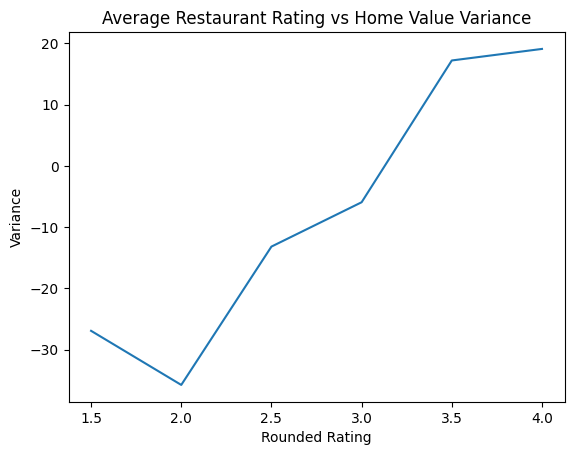

Correlation between rating and home value compared to cluster average when scores below 1 and above 4 are removed: 0.23409602539754526


In [4]:
def average_restaurant_rating_vs_home_value_mid_only():
    # This function will only consider the middle range over 1 and under 4
    spark = SparkSession.builder.master("local[8]").appName("Restaurant Home Prices").getOrCreate()

    clusters_df = spark.read.option("multiline",True).json("input/cluster") 

    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    
    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating")
    restaurants_df = restaurants_df.withColumnRenamed("zip_code", "business_zipcode")
    # Join with combined_df
    combined_df = clusters_df.join(restaurants_df, clusters_df.zip_code == restaurants_df.business_zipcode, "inner")  
    combined_df = combined_df.drop("business_zipcode")
    combined_df = combined_df.dropDuplicates()      
    # remove the scores above 4 and below 1
    combined_df = combined_df.filter(col("rating") < 4)
    combined_df = combined_df.filter(col("rating") > 1)

    # Get the average yelp review score for each 'zip_code'
    average_df = combined_df.groupBy("zip_code").agg(avg("rating").alias("avg_rating"))
    agg_df = combined_df.groupBy("zip_code").agg(collect_list("alias").alias("restaurants"))
    average_df = average_df.join(combined_df, "zip_code", "inner")
    average_df = average_df.join(agg_df, "zip_code", "inner")
    average_df = average_df.drop("alias")
    average_df = average_df.drop("rating")
    average_df = average_df.dropDuplicates()  

    variance_df = average_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
    variance_df = variance_df.withColumn("rounded_rating", expr("round(avg_rating * 2) / 2"))
    chart_df = variance_df.groupBy("rounded_rating").agg(avg("variance").alias("variance")).sort("rounded_rating")
    chart_df.show()

    # Plotting the chart
    x = chart_df.select("rounded_rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("variance").rdd.flatMap(lambda x: x).collect()
    
    plt.plot(x, y)
    plt.xlabel("Rounded Rating")
    plt.ylabel("Variance")
    plt.title("Average Restaurant Rating vs Home Value Variance")
    plt.show()    

    correlation = variance_df.corr("avg_rating", "variance")
    print("Correlation between rating and home value compared to cluster average when scores below 1 and above 4 are removed:", correlation)


    spark.stop()

average_restaurant_rating_vs_home_value_mid_only()

+------+------------------+
|rating|  avg_review_count|
+------+------------------+
|   1.0|1.8449612403100775|
|   1.1|              25.8|
|   1.2| 29.25925925925926|
|   1.3|22.301204819277107|
|   1.4| 32.68493150684932|
|   1.5|32.572916666666664|
|   1.6|  41.2952380952381|
|   1.7|37.333333333333336|
|   1.8| 47.45238095238095|
|   1.9| 70.45967741935483|
|   2.0| 29.40776699029126|
|   2.1| 69.18461538461538|
|   2.2| 66.03875968992249|
|   2.3|38.333333333333336|
|   2.4| 56.73170731707317|
|   2.5| 53.48908296943232|
|   2.6| 62.45454545454545|
|   2.7| 91.39893617021276|
|   2.8| 91.53679653679653|
|   2.9| 96.84408602150538|
+------+------------------+
only showing top 20 rows



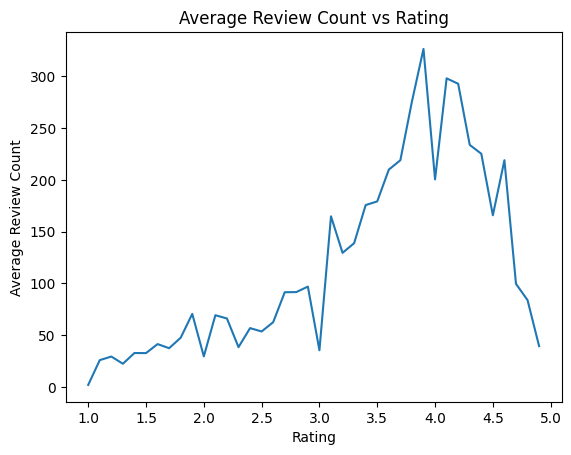

Correlation between rating score and number of reviews: 0.1969507615811921


In [5]:
def correlation_between_number_of_ratings_and_rating():
    spark = SparkSession.builder.master("local[8]").appName("Number Of Ratings Comparision").getOrCreate()

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    # remove restauarants with no review count
    restaurants_df = restaurants_df.filter("review_count > 0")
    # Remove restaurants with a rating of 5.0
    restaurants_df = restaurants_df.filter("rating != 5.0")
    # restaurants_df.show()

    chart_df = restaurants_df.groupBy("rating").agg(avg("review_count").alias("avg_review_count")).sort("rating")
    # Remove 5.0 rating. It is an outlier
    # chart_df = chart_df.filter("rating != 5.0")
    chart_df.show()

    x = chart_df.select("rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("avg_review_count").rdd.flatMap(lambda x: x).collect()

    plt.plot(x, y)
    plt.xlabel("Rating")
    plt.ylabel("Average Review Count")
    plt.title("Average Review Count vs Rating")
    plt.show()

    correlation = restaurants_df.corr("rating", "review_count")
    print("Correlation between rating score and number of reviews:", correlation)

    spark.stop()

correlation_between_number_of_ratings_and_rating()

+------+------------------+
|rating|  avg_review_count|
+------+------------------+
|   1.1|              25.8|
|   1.2| 29.25925925925926|
|   1.3|22.301204819277107|
|   1.4| 32.68493150684932|
|   1.5|32.572916666666664|
|   1.6|  41.2952380952381|
|   1.7|37.333333333333336|
|   1.8| 47.45238095238095|
|   1.9| 70.45967741935483|
|   2.0| 29.40776699029126|
|   2.1| 69.18461538461538|
|   2.2| 66.03875968992249|
|   2.3|38.333333333333336|
|   2.4| 56.73170731707317|
|   2.5| 53.48908296943232|
|   2.6| 62.45454545454545|
|   2.7| 91.39893617021276|
|   2.8| 91.53679653679653|
|   2.9| 96.84408602150538|
|   3.0| 35.30855855855856|
+------+------------------+
only showing top 20 rows



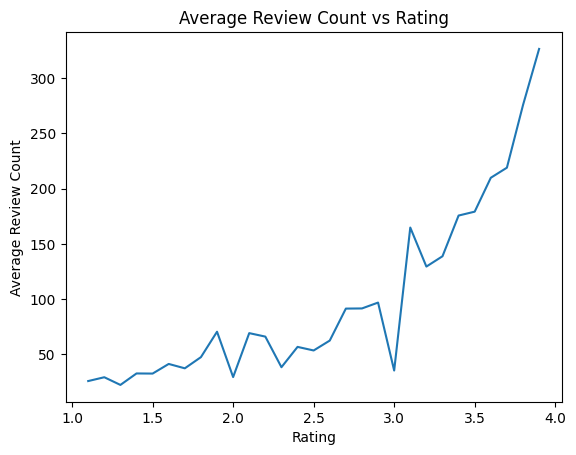

Correlation between rating score and number of reviews: 0.2880933315114705


In [6]:
def correlation_between_number_of_ratings_and_rating_mid_only():
    # Explore correlation if the scores below 1 and above 4 are removed
    spark = SparkSession.builder.master("local[8]").appName("Number Of Ratings Comparision").getOrCreate()

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    # remove restauarants with no review count
    restaurants_df = restaurants_df.filter("review_count > 0")
    # Remove restaurants with a rating of < 1 and > 4
    restaurants_df = restaurants_df.filter("rating > 1.0")
    restaurants_df = restaurants_df.filter("rating < 4.0")
    # restaurants_df = restaurants_df.filter("rating != 5.0")
    # restaurants_df.show()

    chart_df = restaurants_df.groupBy("rating").agg(avg("review_count").alias("avg_review_count")).sort("rating")
    # Remove 5.0 rating. It is an outlier
    # chart_df = chart_df.filter("rating != 5.0")
    chart_df.show()

    x = chart_df.select("rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("avg_review_count").rdd.flatMap(lambda x: x).collect()

    plt.plot(x, y)
    plt.xlabel("Rating")
    plt.ylabel("Average Review Count")
    plt.title("Average Review Count vs Rating")
    plt.show()

    correlation = restaurants_df.corr("rating", "review_count")
    print("Correlation between rating score and number of reviews:", correlation)

    spark.stop()

correlation_between_number_of_ratings_and_rating_mid_only()

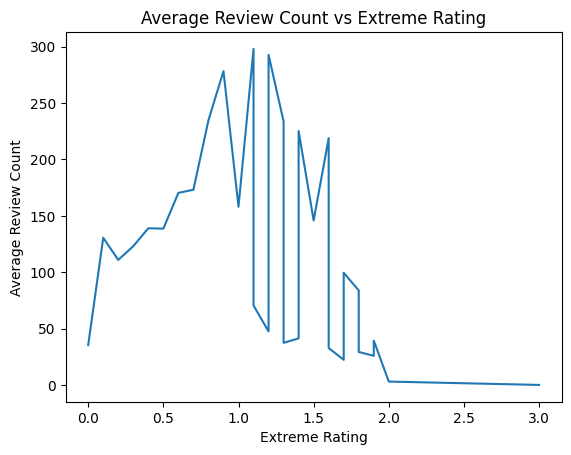

Correlation between extreme rating score and number of reviews: -0.21551791332049994


In [7]:
def ratings_vs_extreme():
    spark = SparkSession.builder.master("local[8]").appName("Number Of Ratings Comparision").getOrCreate()

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    # make 2.5 rating 0 anything under is negative and anything over is positive then get the abs value
    restaurants_df = restaurants_df.withColumn("extreme_rating", expr("abs(3 - rating)"))
    # restaurants_df.show()

    chart_df = restaurants_df.groupBy("extreme_rating").agg(avg("review_count").alias("avg_review_count")).sort("extreme_rating")

    x = chart_df.select("extreme_rating").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("avg_review_count").rdd.flatMap(lambda x: x).collect()
    plt.plot(x, y) 
    plt.xlabel("Extreme Rating")
    plt.ylabel("Average Review Count")
    plt.title("Average Review Count vs Extreme Rating")
    plt.show()

    correlation = restaurants_df.corr("extreme_rating", "review_count")
    print("Correlation between extreme rating score and number of reviews:", correlation)

ratings_vs_extreme()

In [8]:

def price_correlation_between_starbucks_and_home_value():
        spark = SparkSession.builder.master("local[8]").appName("Starbucks Comparision").getOrCreate()

        clusters_df = spark.read.option("multiline",True).json("input/cluster") 

        clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
        clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
        clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")
    
        clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
        clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

        starbucks_df = spark.read.option("multiline",True).json("input/yelp/starbucks") 
        starbucks_df = starbucks_df.select(explode("businesses").alias("business"))
        starbucks_df = starbucks_df.select("business.alias", "business.location.zip_code",)
        starbucks_df = starbucks_df.withColumnRenamed("zip_code", "starbucks_zip_code")
        starbucks_df = starbucks_df.dropDuplicates()
        # Filter where alias has starbucks in it
        starbucks_df = starbucks_df.filter(starbucks_df['alias'].contains("starbucks"))
        # Add column to count starbucks in zipcode
        starbucks_df = starbucks_df.groupBy("starbucks_zip_code").agg(count("*").alias("count"))

        # join with clusters
        combined_df = clusters_df.join(starbucks_df, clusters_df.zip_code == starbucks_df.starbucks_zip_code, "left")
        # replace null in count with 0
        combined_df = combined_df.na.fill(0, subset=["count"])
        # Add a column that is 1 if the count is > 0 or 0 if < 1
        combined_df = combined_df.withColumn("has_starbucks", expr("IF(count > 0, 1, 0)"))

        variance_df = combined_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
        correlation = variance_df.corr("has_starbucks", "variance")
        print("Correlation between the existence of Starbucks and variance in home values:", correlation)
        correlation = variance_df.corr("count", "variance")
        print("Correlation between number of Starbucks and variance in home values:", correlation)

        # Find the average variance for zip codes with a starbucks and without
        correlation_df = variance_df.groupBy("has_starbucks").agg(avg("variance").alias("avg_variance"))
        correlation_df.show()

        spark.stop()

price_correlation_between_starbucks_and_home_value()

24/05/03 22:08:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Correlation between the existence of Starbucks and variance in home values: 0.06281967287157061
Correlation between number of Starbucks and variance in home values: 0.07632058163703555
+-------------+------------------+
|has_starbucks|      avg_variance|
+-------------+------------------+
|            1| 4.833856438769549|
|            0|-4.498271132089841|
+-------------+------------------+



+-------------+--------------------+
|reviews_count|            variance|
+-------------+--------------------+
|            0| -18.653689490282698|
|            2|   39.50429422908574|
|            3|  19.114640316232418|
|            4|   34.10011341641706|
|            5|  30.507025885619544|
|            8| -33.743621221319884|
|           14| -40.346218872856454|
|           15|  184.64783224263138|
|           16|  -13.99381549468058|
|           17| -1.9102581709192605|
|           20|   5.814807934239091|
|           22|  -70.19137548258362|
|           25|-0.42322974351258225|
|           27|  -58.08706714196229|
|           28| -55.728398401395694|
|           29|  3.6966139344661446|
|           36|  -9.569208211904064|
|           39|   55.92114489417727|
|           41|  -8.013652999238452|
|           42|  -71.38188820571838|
+-------------+--------------------+
only showing top 20 rows



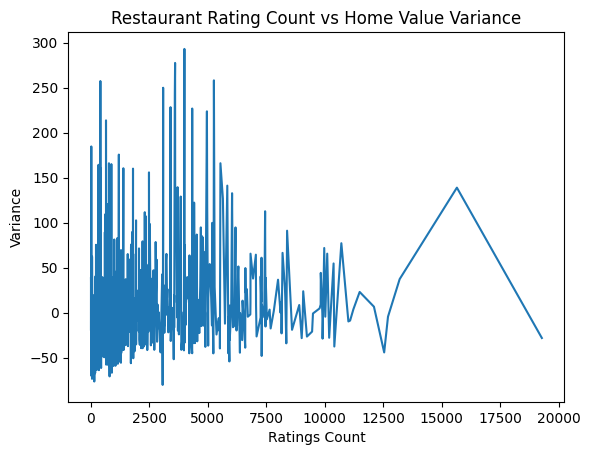

Correlation between rating count and home value compared to cluster average: 0.2191008353438076


In [9]:
def restaurant_ratings_count_to_home_value():
    spark = SparkSession.builder.master("local[8]").appName("Restaurant Ratings Count Comparision").getOrCreate()

    clusters_df = spark.read.option("multiline",True).json("input/cluster") 

    clusters_df = clusters_df.selectExpr("query.average_zhvi", "query.code", "explode(results) as result")  
    clusters_df = clusters_df.withColumnRenamed("code", "cluster_code")
    clusters_df = clusters_df.withColumnRenamed("average_zhvi", "cluster_average_zhvi")

    clusters_df = clusters_df.select("cluster_code", "cluster_average_zhvi", "result.code", "result.zhvi")
    clusters_df = clusters_df.withColumnRenamed("code", "zip_code")

    # Now get restaurant data and combine with combined_df
    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants")
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating", "business.review_count")
    restaurants_df = restaurants_df.withColumnRenamed("zip_code", "business_zipcode")

    restaurants_df = restaurants_df.withColumn("review_count", col("review_count").cast("int"))
    # Get sum of review_count in a zipcode
    restaurants_df = restaurants_df.groupBy("business_zipcode").agg(_sum("review_count").alias("reviews_count"))

    combined_df = clusters_df.join(restaurants_df, clusters_df.zip_code == restaurants_df.business_zipcode, "inner")

    variance_df = combined_df.withColumn("variance", expr("(zhvi - cluster_average_zhvi) / cluster_average_zhvi * 100"))
    # remove where variance is null
    variance_df = variance_df.filter("variance IS NOT NULL")
    chart_df = variance_df.groupBy("reviews_count").agg(avg("variance").alias("variance")).sort("reviews_count")
    
    chart_df.show()

    # Plotting the chart
    x = chart_df.select("reviews_count").rdd.flatMap(lambda x: x).collect()
    y = chart_df.select("variance").rdd.flatMap(lambda x: x).collect()  
    plt.plot(x, y)
    plt.xlabel("Ratings Count")
    plt.ylabel("Variance")
    plt.title("Restaurant Rating Count vs Home Value Variance")
    plt.show()

    correlation = variance_df.corr("reviews_count", "variance")
    print("Correlation between rating count and home value compared to cluster average:", correlation)
    
restaurant_ratings_count_to_home_value()
    

In [10]:
def restaurant_count_correlation_to_rating():
    spark = SparkSession.builder.master("local[8]").appName("Cont Comparision").getOrCreate()

    restaurants_df = spark.read.option("multiline",True).json("input/yelp/restaurants") 
    restaurants_df = restaurants_df.select(explode("businesses").alias("business"))
    # I want the 'alias' 'location.zip_code', 'review_count'  'rating'
    restaurants_df = restaurants_df.select("business.alias", "business.location.zip_code", "business.rating")
    # group by zip code and count the number of restaurants 
    restaurant_count = restaurants_df.groupBy("zip_code").agg(count("*").alias("count") )
    restaurant_count = restaurant_count.withColumnRenamed("zip_code", "restaurant_zip_code")
    # I need the average rating of the restaurants in the zip code
    restaurant_avg_rating = restaurants_df.groupBy("zip_code").agg(avg("rating").alias("avg_rating") )
    # join with restaurants
    combined_df = restaurants_df.join(restaurant_count, restaurants_df["zip_code"] == restaurant_count["restaurant_zip_code"], "inner")
    combined_df = combined_df.join(restaurant_avg_rating, restaurants_df["zip_code"] == restaurant_avg_rating["zip_code"], "inner")

    correlation = combined_df.corr("count", "avg_rating")
    print("Correlation between a zip code's restaurant count and rating:", correlation)

restaurant_count_correlation_to_rating()


24/05/03 22:08:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Correlation between a zip code's restaurant count and rating: 0.0013443895350569342
